In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
stop_words = stopwords.words('english')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from stop import stop_words
from textblob import TextBlob
import requests
from pycomp.viz.insights import *
from collections import Counter
import gensim
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from zeugma.embeddings import EmbeddingTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_text.txt').text
label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/train_labels.txt').text
val_text = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_text.txt').text
val_label = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/val_labels.txt').text
text_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_text.txt').text
label_test = requests.get('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/offensive/test_labels.txt').text

In [3]:
def process(label,text):
    
    tag = []
    for sent in label.split("\n"):
        try:
            tag.append(int(sent))
        except ValueError:
            pass

    tweet = []
    for text in text.split('\n'):
        try:
            tweet.append(text)
        except ValueError:
            pass
        
    data = {'tweet':tweet[:-1],'tag':tag}
    df = pd.DataFrame(data)
    df['class'] = df.tag.apply(lambda x:'not-offensive' if x==0 else 'offensive')
    return df

In [4]:
df = process(label,text)
df_val = process(val_label,val_text)
df_test = process(label_test,text_test)

In [5]:
df

,tweet,tag,class
0,@user Bono... who cares. Soon people will unde...,0,not-offensive
1,@user Eight years the republicans denied obama...,1,offensive
2,@user Get him some line help. He is gonna be j...,0,not-offensive
3,@user @user She is great. Hi Fiona!,0,not-offensive
4,@user She has become a parody unto herself? Sh...,1,offensive
...,...,...,...
11911,@user I wonder if they are sex traffic victims?,1,offensive
11912,@user Do we dare say he is... better than Nyjer?,0,not-offensive
11913,@user No idea who he is. Sorry,0,not-offensive
11914,#Professor Who Shot Self Over Trump Says Gun C...,0,not-offensive


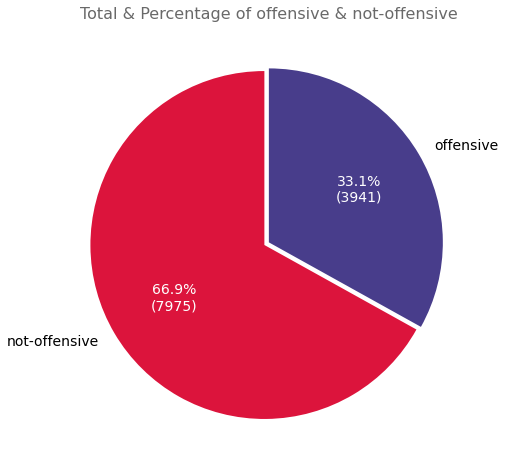

In [6]:
plot_pie_chart(df=df, col='class', colors=['crimson', 'darkslateblue', 'darkgrey'],
               explode=(0.03, 0),
               title="Total & Percentage of offensive & not-offensive")

In [7]:
words = set(nltk.corpus.words.words())

def cleaner(tweet):
    
    tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", tweet)
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = ([word for word in tweet if not word in stop_words])
#     tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet])
    tweet = " ".join([stemmer.stem(word) for word in tweet])
    
    tweet = tweet.replace("user", "")


    return  tweet

In [8]:
def cleanup(df):
    
    train_cleaned = df['tweet'].apply(cleaner)
    df['tweet'] = train_cleaned.apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return df 

In [9]:
train_cleaned = cleanup(df)
val_cleaned = cleanup(df_val)
test_cleaned = cleanup(df_test)

In [10]:
train_cleaned

,tweet,tag,class
0,bono care soon peopl understand gain noth foll...,0,not-offensive
1,eight year republican deni obama pick breitbar...,1,offensive
2,get line help gonna fine game went could see p...,0,not-offensive
3,great hi fiona,0,not-offensive
4,becom parodi unto certainli taken heat anwel i...,1,offensive
...,...,...,...
11911,wonder sex traffic victim,1,offensive
11912,dare say better nyjer,0,not-offensive
11913,no idea sorri,0,not-offensive
11914,professor shot self trump say gun control actu...,0,not-offensive


In [11]:
from PIL import Image
mask = np.array(Image.open("/Users/karampruthi/Downloads/twitter.png"))
def word_cloud(sentiment):
    
    negative_words = ' '.join([text for text in train_cleaned['tweet'][train_cleaned['class']==sentiment]])
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(random_state=21, max_font_size=110,contour_color='red',
                          font_path = '/Users/karampruthi/Downloads/reglisse/Reglisse_Fill.otf',
                          background_color='white',mask=mask,
                          stopwords=stop_words).generate(negative_words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    
    plt.title(sentiment+' Words', fontsize=35,color = 'darkslateblue',family='serif',weight = 'heavy')

,Common_words,count
0,not,962
1,liber,899
2,gun,889
3,antifa,764
4,control,706
5,conserv,686
6,maga,641
7,like,621
8,dont,524
9,get,514


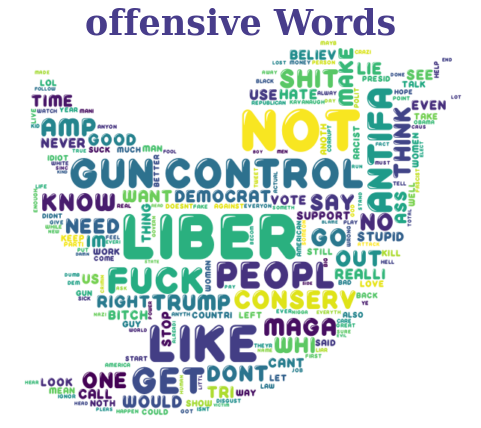

In [12]:
word_cloud('offensive')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==0].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

,Common_words,count
0,liber,572
1,not,519
2,gun,493
3,like,445
4,control,402
5,peopl,340
6,dont,314
7,shit,303
8,get,291
9,fuck,288


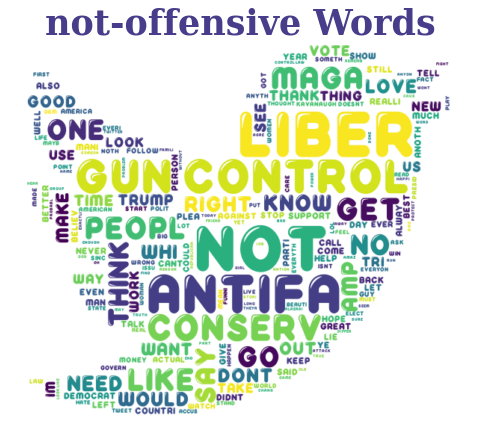

In [13]:
word_cloud('not-offensive')

train = pd.DataFrame()
train['temp_list'] = train_cleaned['tweet'][train_cleaned['tag']==1].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='viridis')

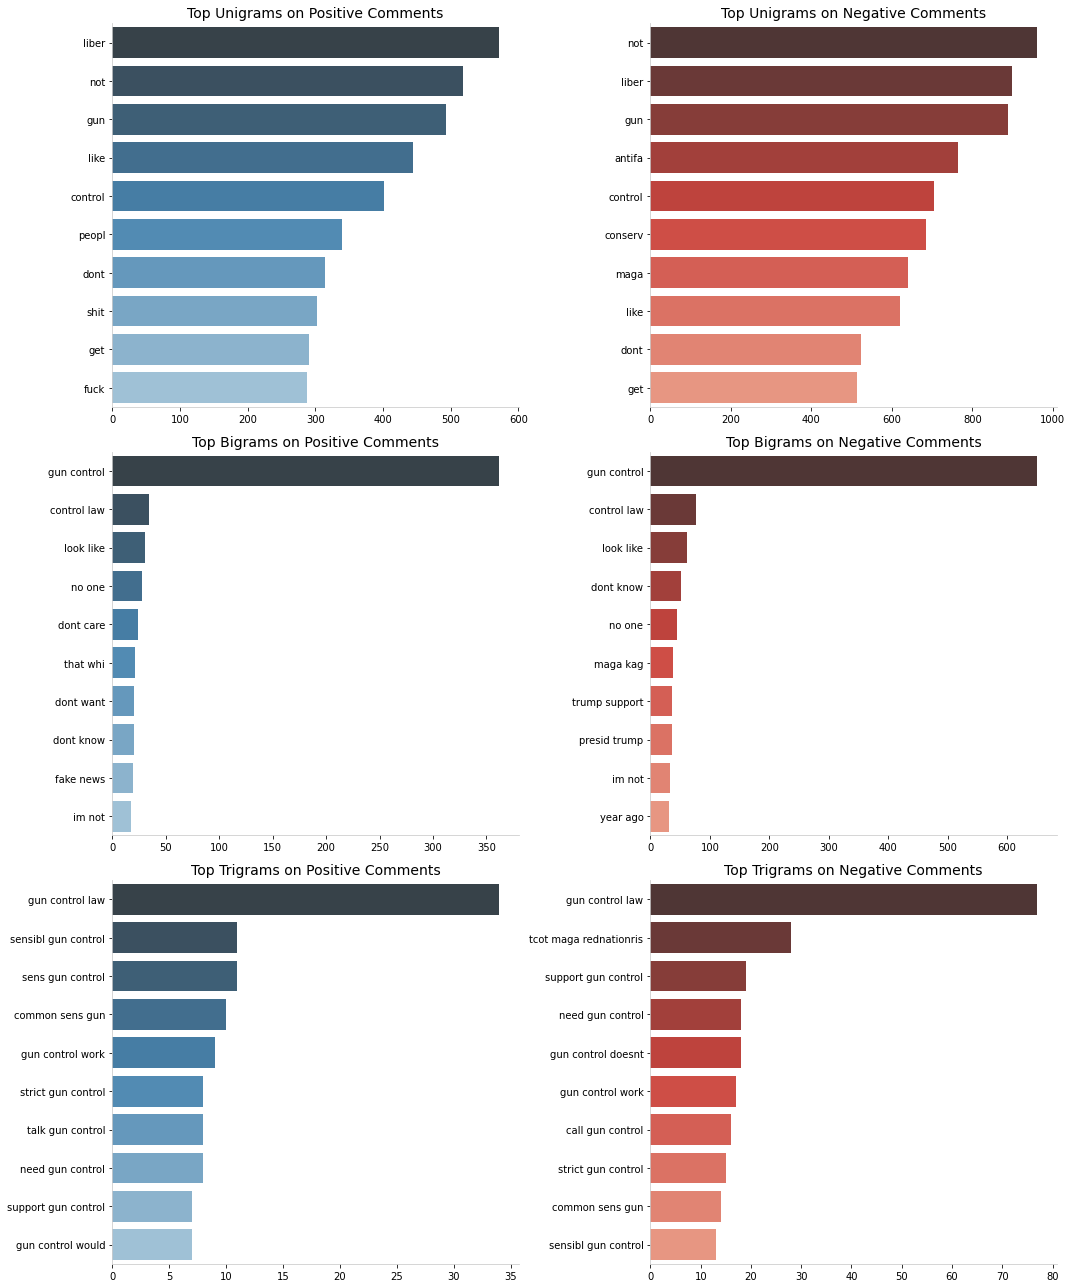

In [14]:
def ngrams_count(corpus, ngram_range, n=-1):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer( ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

# Splitting the corpus into positive and negative comments
positive_comments = train_cleaned['tweet'][train_cleaned['class']=='offensive']
negative_comments = train_cleaned['tweet'][train_cleaned['class']=='not-offensive']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)


# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)



# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)



# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d','Greens_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1

plt.tight_layout()
plt.show()

# OverSampling to handle imbalance train dataset

In [15]:
train_cleaned['tweet'].shape

(11916,)

In [16]:
from imblearn.over_sampling import RandomOverSampler

inputs = train_cleaned['tweet'].values.reshape(-1,1)
target = train_cleaned['tag']
smote = RandomOverSampler()
inputs, target = smote.fit_sample(inputs,target)

inputs = inputs.reshape(inputs.shape[0],)

In [17]:
inputs.shape

(15950,)

# Feature Extraction

# Bag of Words

In [18]:
def Bag_words(vect, x_train, y_train, validation, test, ngram):
    
    c = vect(ngram_range=(1,ngram))

    x_train = c.fit_transform(inputs)
    shape = x_train.shape 
    if ngram==1:
        print('Train size with Unigram:',shape)
    elif ngram ==2:
        print('Train size with Bigram:',shape)
    elif ngram ==3:
        print('Train size with Trigram:',shape)
        
    val_train = c.transform(validation['tweet'].values)
    test_train = c.transform(test['tweet'].values)
    LR= LogisticRegression(max_iter=500)  
    LR.fit(x_train,target)
    val_pred = LR.predict(val_train)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(test_train)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

#  CountVectorizer

In [19]:
for i in range(1,4):
    Bag_words(CountVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (15950, 14501)
F1 Score on Validation Data --> 0.7165345126289113
F1 Score on Test Data       --> 0.7388543823326432 

Train size with Bigram: (15950, 106485)
F1 Score on Validation Data --> 0.7268829220715498
F1 Score on Test Data       --> 0.7449437226932092 

Train size with Trigram: (15950, 207796)
F1 Score on Validation Data --> 0.7197868391634197
F1 Score on Test Data       --> 0.7429459588713534 



# TF-IDF

In [20]:
for i in range(1,4):
    Bag_words(TfidfVectorizer,inputs,target,val_cleaned,test_cleaned,i)

Train size with Unigram: (15950, 14501)
F1 Score on Validation Data --> 0.7146852864022973
F1 Score on Test Data       --> 0.7459221595061498 

Train size with Bigram: (15950, 106485)
F1 Score on Validation Data --> 0.6973858308739591
F1 Score on Test Data       --> 0.7331778085587227 

Train size with Trigram: (15950, 207796)
F1 Score on Validation Data --> 0.6993149664929263
F1 Score on Test Data       --> 0.7388075354177049 



# Word2Vec

In [21]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv.vocab]
    if len(doc)==0:
        doc = ['like']
    return np.mean(w2v[doc], axis=0)

def Word_Vec(x_train,y_train, validation, test):
    
    x_train = pd.DataFrame(x_train)
    words_train = x_train[0].apply(word_tokenize)
    words_validation = validation['tweet'].apply(word_tokenize)
    words_test = test['tweet'].apply(word_tokenize)
    
    global w2v
    w2v = gensim.models.Word2Vec(words_train, size=350, window=10, min_count=1, iter=20)
    words_train = pd.DataFrame(words_train)
    words_validation = pd.DataFrame(words_validation)
    words_test = pd.DataFrame(words_test)

    x_train = list(words_train[0].apply(document_vector))
    x_val = list(words_validation['tweet'].apply(document_vector))
    x_test = list(words_test['tweet'].apply(document_vector))
    
    LR = LogisticRegression(C=500,multi_class='multinomial')
    LR.fit(x_train,y_train)
    
    val_pred = LR.predict(x_val)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(x_test)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

In [22]:
print('*******WORD2VEC********')
Word_Vec(inputs, target, val_cleaned,test_cleaned)

*******WORD2VEC********
F1 Score on Validation Data --> 0.6320436893203882
F1 Score on Test Data       --> 0.6799200039614651 



# Matrix Factorization with Glove

In [23]:
def Glove(x_train, y_train, validation, test):
    
    x_train = glove.transform(x_train)
    x_val = glove.transform(validation['tweet'])
    x_test = glove.transform(test['tweet'])
    
    LR = LogisticRegression(max_iter=500) 
    LR.fit(x_train,y_train)
    val_pred = LR.predict(x_val)
    print('F1 Score on Validation Data -->',f1_score(validation['tag'],val_pred,average='macro'))
    
    test_pred = LR.predict(x_test)
    print('F1 Score on Test Data       -->',f1_score(test['tag'],test_pred,average='macro'),'\n')

In [24]:
glove = EmbeddingTransformer('glove')
print('******GLOVE******')
Glove(inputs,target,val_cleaned,test_cleaned)

******GLOVE******
F1 Score on Validation Data --> 0.6451442293947797
F1 Score on Test Data       --> 0.6602188116331211 

